In [5]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import random
import hypernetx as hnx
import os
import sys
import pickle
from sklearn.preprocessing import MinMaxScaler

#from GraphRicciCurvature.OllivierRicci import OllivierRicci

source_path = os.path.abspath("../utilities/")
sys.path.append(source_path)
import utils as ut
import hypergraph_generation as genhyp
import centrality as central
import curvature as curv
import plotting as plt2

( nodes x hyperedges ): B.shape=(15, 10)
A.shape=(15, 15)


/home/sgolts/.conda/envs/porky/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


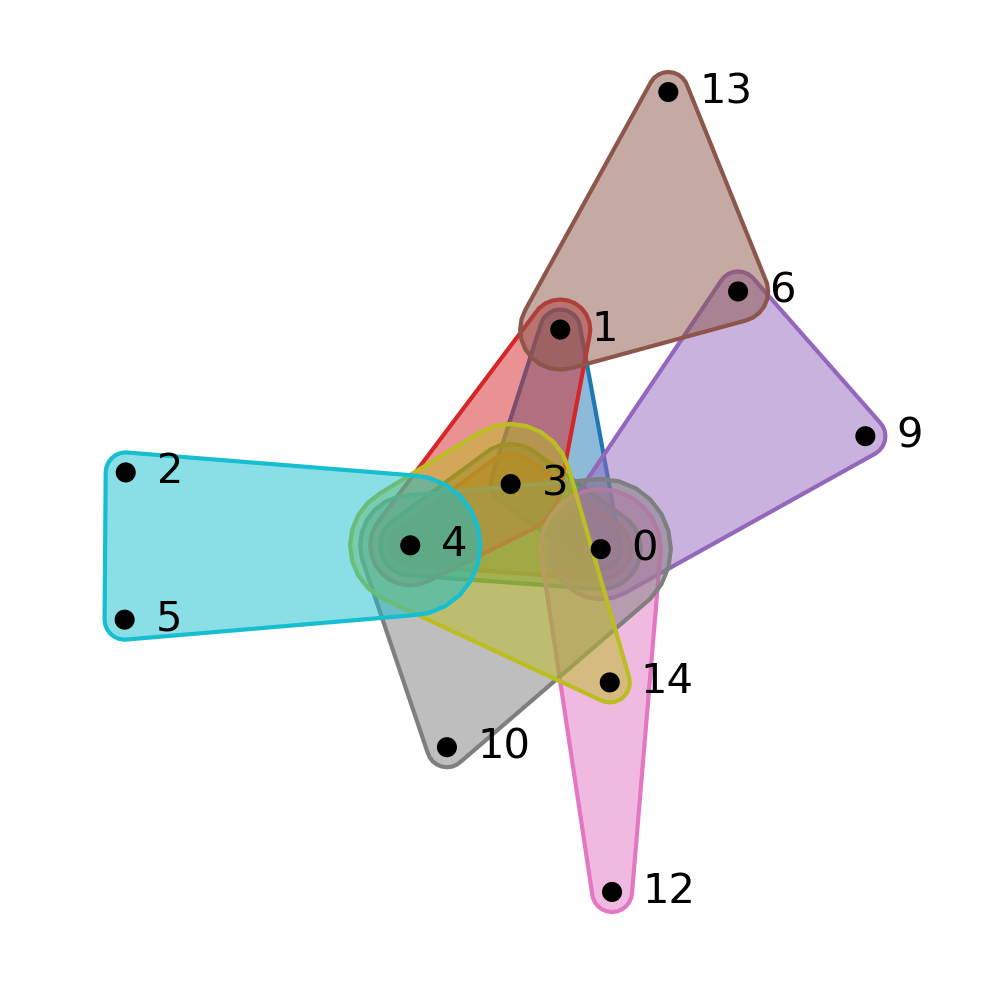

In [6]:
num_core_nodes = 5
num_periphery_nodes = 10
edge_probability_core = 0.95
edge_probability_periphery = 0.075
avg_edge_size = 3
core_periphery_probability = 0.125

CP = genhyp.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

B = pd.DataFrame(incidence_matrix)
print(f"( nodes x hyperedges ): {B.shape=}")
hyperedges = ut.incidence_to_hyperedge_dict(B)

# get layout from clique expansion
A = pd.DataFrame(
    B @ B.T, 
    index=B.index, 
    columns=B.index,
)

G = nx.from_pandas_adjacency(A)
pos = nx.spring_layout(G)

print(f"{A.shape=}")

# Create the HyperNetX hypergraph
H = hnx.Hypergraph(hyperedges)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

hnx.draw(
    H, 
    pos=pos, 
    fill_edges=True,
    node_label_alpha=0.0, 
    edge_label_alpha=0.0,
    with_edge_labels=False,
)

plt.gcf().set_facecolor('none')

# Generate a big one

In [7]:
num_core_nodes = 250
num_periphery_nodes = 1000
edge_probability_core = 0.95
edge_probability_periphery = 0.075
avg_edge_size = 3
core_periphery_probability = 0.125

CP = genhyp.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

B = pd.DataFrame(incidence_matrix)
print(f"( nodes x hyperedges ): {B.shape=}")

( nodes x hyperedges ): B.shape=(1250, 31562)


# Metrics

In [8]:
%%time
# HEVC
node_ev, edge_ev = central.hevc(B, function='linear')
print(f"{len(node_ev)=} {type(node_ev)=}")
print(f"{len(edge_ev)=} {type(edge_ev)=}")

len(node_ev)=1250 type(node_ev)=<class 'numpy.ndarray'>
len(edge_ev)=31562 type(edge_ev)=<class 'numpy.ndarray'>
CPU times: user 489 ms, sys: 17.7 ms, total: 507 ms
Wall time: 517 ms


In [9]:
%%time
# HLRC
blist = ut.incidence_to_list_of_list(B)
hlrc = curv.compute_hlrc(blist)
print(f"{len(hlrc)=} {type(hlrc)=}")

len(hlrc)=31562 type(hlrc)=<class 'list'>
CPU times: user 1.14 s, sys: 4.84 ms, total: 1.15 s
Wall time: 1.16 s


In [10]:
%%time
# FRC
frc = curv.compute_forman_curvature(B)
print(f"{len(frc)=} {type(frc)=}")

len(frc)=31562 type(frc)=<class 'pandas.core.series.Series'>
CPU times: user 53 s, sys: 482 ms, total: 53.5 s
Wall time: 53.7 s


# compile as dataframe

In [11]:
df = pd.DataFrame({
    'hevc' : list(edge_ev),
    'hlrc' : list(hlrc),
    'frc' : list(frc),
})

print(f"{df.shape=}")
print(df.head().to_string())
print()

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])
print(df.head().to_string())

df.shape=(31562, 3)
       hevc      hlrc    frc
0  0.000059 -0.915002 -478.0
1  0.000049 -0.838875 -444.0
2  0.000054 -0.871466 -459.0
3  0.000048 -0.953718 -429.0
4  0.000052 -0.916918 -444.0

       hevc      hlrc       frc
0  0.637970 -0.669683 -0.840000
1  0.295572 -0.279514 -0.658667
2  0.484199 -0.446548 -0.738667
3  0.238466 -0.868112 -0.578667
4  0.390822 -0.679502 -0.658667


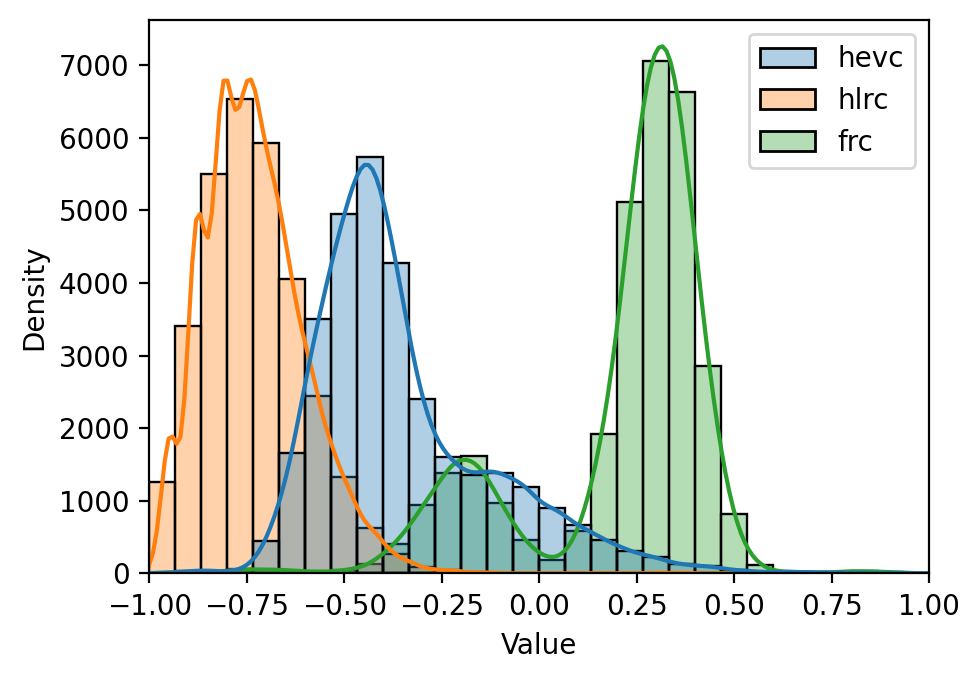

In [12]:

cols = ['hevc', 'hlrc', 'frc']
long = df[cols].melt(var_name='feature', value_name='value')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3.5
sns.histplot(
    data=long, x='value', hue='feature',
    bins=30, kde=True, common_bins=True,
    alpha=0.35,
)
plt.xlim(-1, 1)
plt.xlabel('Value')
plt.ylabel('Density')
sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
)
plt.tight_layout()
plt.show()

In [30]:
num_core_nodes = 5
num_periphery_nodes = 20
edge_probability_core = 0.95
edge_probability_periphery = 0.075
avg_edge_size = 3
core_periphery_probability = 0.125

CP = genhyp.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

B = pd.DataFrame(incidence_matrix)
print(f"( nodes x hyperedges ): {B.shape=}")

( nodes x hyperedges ): B.shape=(25, 17)


In [31]:
VH = B
F = curv.compute_forman_curvature(VH)

In [32]:
import networkx as nx

In [33]:
edge_dict = {e: list(B.index[B[e]]) for e in B.columns}
H = hnx.Hypergraph(edge_dict)

In [34]:
# Normalize curvature for color mapping
curvy = F.loc[list(H.edges)]  # Make sure ordering is correct
norm = plt.Normalize(curvy.min(), curvy.max())
cmap = plt.cm.viridis  # Choose your favorite colormap

edge_colors = {e: cmap(norm(curvy[e])) for e in H.edges}

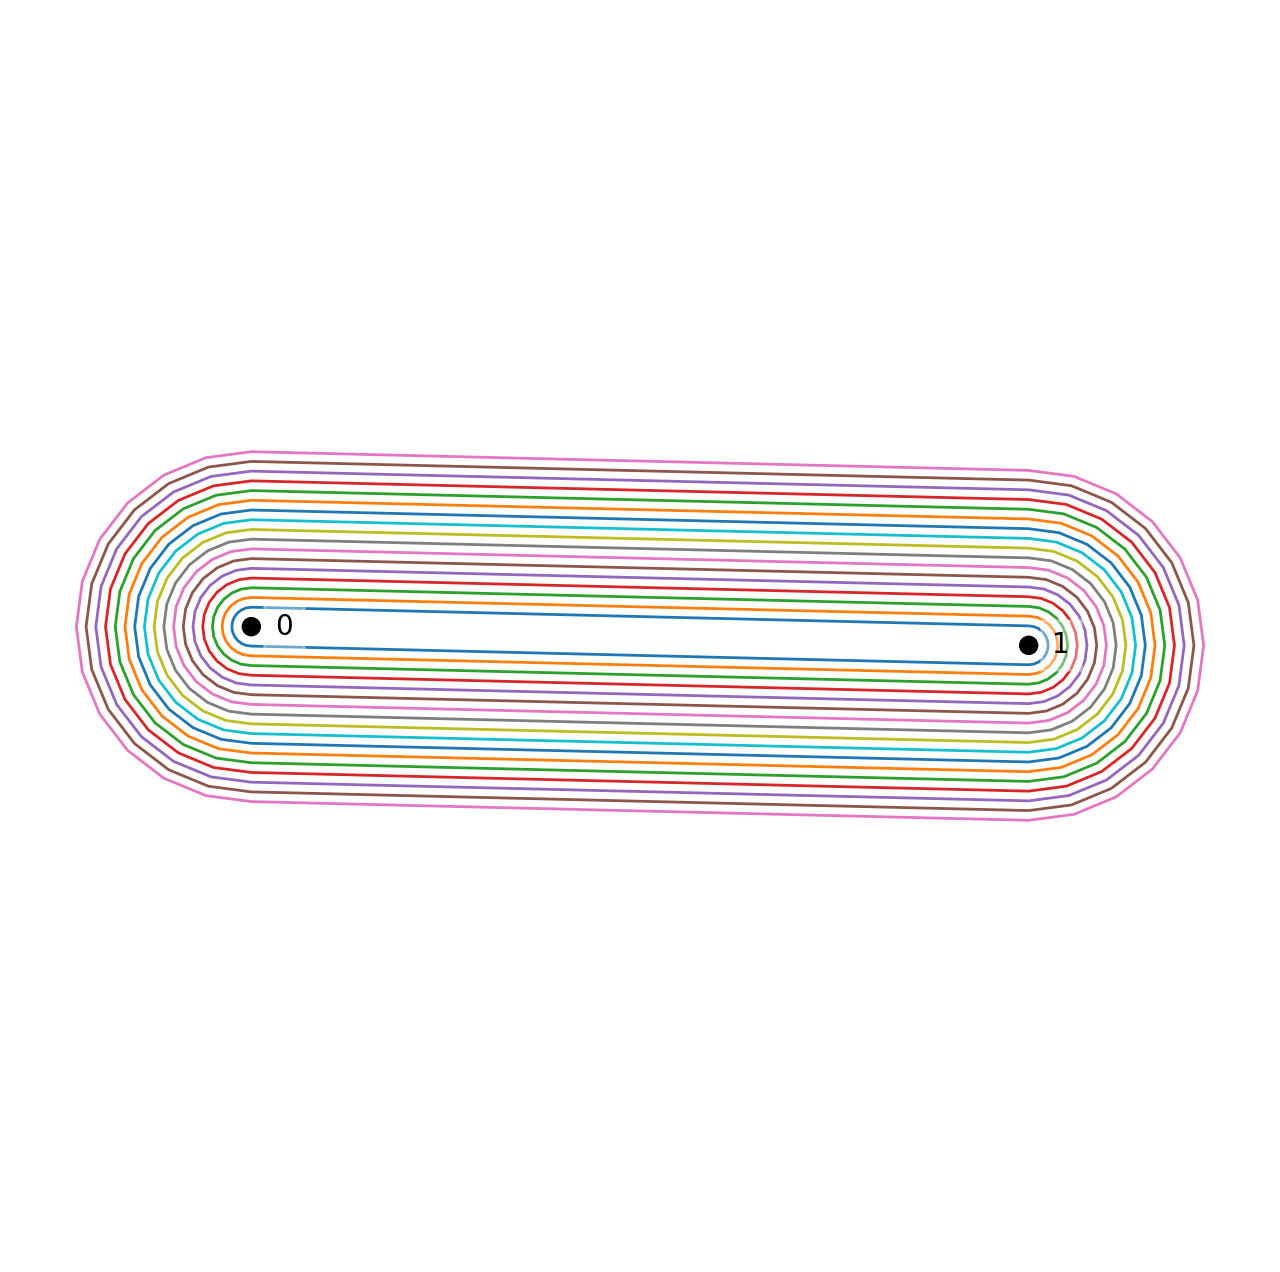

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))

hnx.drawing.draw(
    H,
    ax=ax,
    #edge_color=edge_colors,  # Dict: edge label → RGBA
    with_edge_labels=False
)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# # Colorbar for reference
# plt.colorbar(sm, ax=ax, label="Forman curvature")

# plt.show()

( nodes x hyperedges ): B.shape=(15, 10)
A.shape=(15, 15)


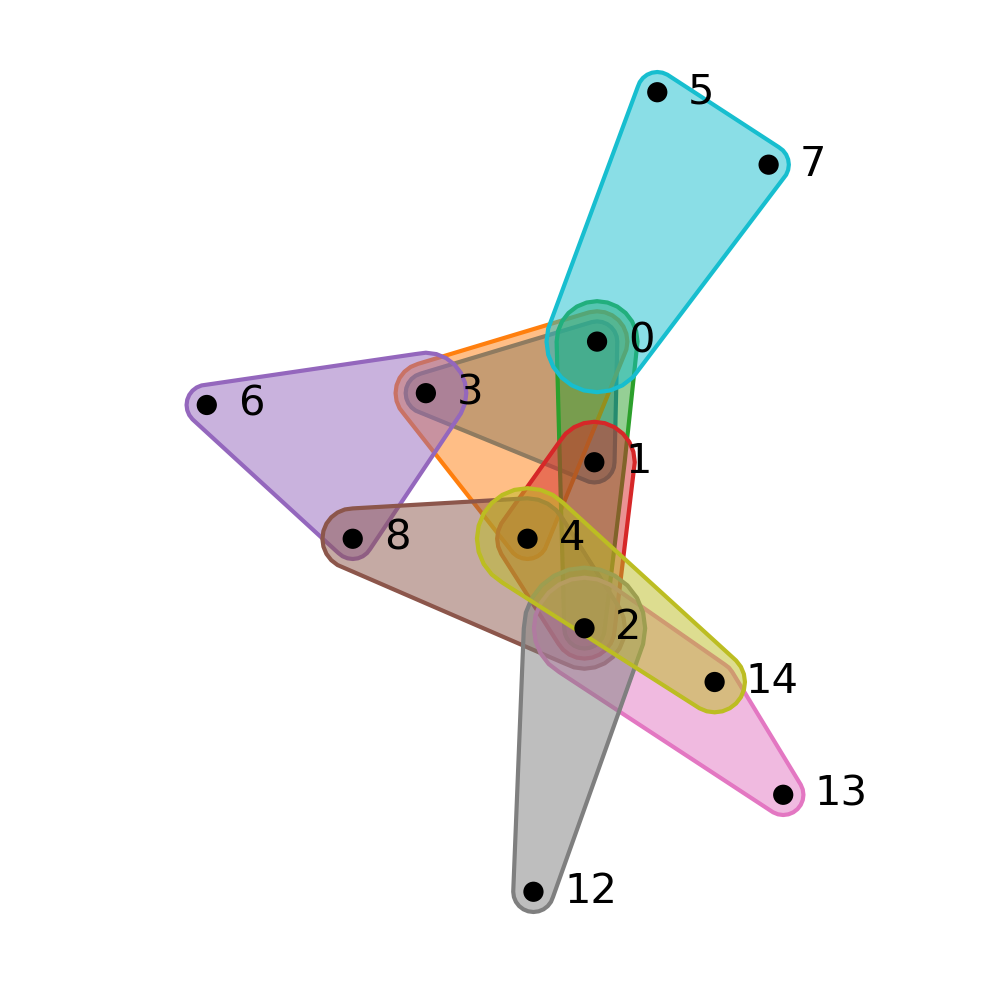

In [37]:
num_core_nodes = 5
num_periphery_nodes = 10
edge_probability_core = 0.95
edge_probability_periphery = 0.075
avg_edge_size = 3
core_periphery_probability = 0.125

CP = genhyp.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

B = pd.DataFrame(incidence_matrix)
print(f"( nodes x hyperedges ): {B.shape=}")
hyperedges = ut.incidence_to_hyperedge_dict(B)

# get layout from clique expansion
A = pd.DataFrame(
    B @ B.T, 
    index=B.index, 
    columns=B.index,
)

G = nx.from_pandas_adjacency(A)
pos = nx.spring_layout(G)

print(f"{A.shape=}")

# Create the HyperNetX hypergraph
H = hnx.Hypergraph(hyperedges)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

hnx.draw(
    H, 
    pos=pos, 
    fill_edges=True,
    node_label_alpha=0.0, 
    edge_label_alpha=0.0,
    with_edge_labels=False,
)

plt.gcf().set_facecolor('none')